# Capstone Analysis


# Index
- [Capstone Objectives](#Capstone-Objectives)
- [Read in Data](#Read-in-Data)
    - [Merge 2018 and 2019](#Merge-2018-and-2019)
    - [Make advisor dictionary mapper](#Make-advisor-dictionary-mapper)
- [Data Cleaning](#Data-Cleaning)
    - [Train-Test-Split](#Train-Test-Split)
    - [Custom Cleaning Functions](#Custom-Cleaning-Functions)
    - [Create Cleaning Pipeline](#Create-Cleaning-Pipeline)
- [Model building](#Model-building)
- [Make predictions](#Make-predictions)
    - [Regression](#Regression)
        - [Make Function to output deciles](#Make-Function-to-output-deciles)
    - [Classification](#Classification)
        - [Balance the data with `imbalanced-learn`](#Balance-the-data-with-imbalanced-learn)
    - [Model Interpretation](#Model-Interpretation)
- [Scratch Work](#Scratch-Work)
    - [Feature Engineering](#Feature-Engineering)
        - [Variable Inflation Factor (VIF)](#Variable-Inflation-Factor-(VIF))
    - [Residuals](#Residuals)
    - [Condition number](#Condition-number)

# Capstone Objectives
- Assist sales and marketing by improving their targeting
- Predict sales for 2019 using the data for 2018
- Estimate the probability of adding a new fund in 2019

In [63]:
import numpy as np
import pandas as pd
from pandas import Grouper
import matplotlib.pyplot as plt
import math


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import classification_report
import sklearn.metrics

import seaborn as sns


pd.set_option('display.max_columns', 50)

In [64]:
df18 = pd.read_excel(r'C:\Users\prade\Desktop\Emeritus\Capstone Assignment - Nuveen Sales Data Analysis/Transaction Data.xlsx', sheet_name="Transactions18")
df19 = pd.read_excel(r'C:\Users\prade\Desktop\Emeritus\Capstone Assignment - Nuveen Sales Data Analysis/Transaction Data.xlsx', sheet_name="Transactions19")
firm = pd.read_excel(r'C:\Users\prade\Desktop\Emeritus\Capstone Assignment - Nuveen Sales Data Analysis/Firm Information.xlsx', sheet_name="Rep summary")

# Merge 2018 and 2019

In [65]:
df = pd.merge(
    df18, 
    df19, 
    on='CONTACT_ID',
    suffixes=['_2018', '_2019']
)
print(df.shape)

(10005, 41)


In [66]:
# feature names as a list
col = df18.columns       # .columns gives columns names in data 
print(col)

Index(['CONTACT_ID', 'no_of_sales_12M_1', 'no_of_Redemption_12M_1',
       'no_of_sales_12M_10K', 'no_of_Redemption_12M_10K',
       'no_of_funds_sold_12M_1', 'no_of_funds_redeemed_12M_1',
       'no_of_fund_sales_12M_10K', 'no_of_funds_Redemption_12M_10K',
       'no_of_assetclass_sold_12M_1', 'no_of_assetclass_redeemed_12M_1',
       'no_of_assetclass_sales_12M_10K', 'no_of_assetclass_Redemption_12M_10K',
       'No_of_fund_curr', 'No_of_asset_curr', 'AUM', 'sales_curr', 'sales_12M',
       'redemption_curr', 'redemption_12M', 'new_Fund_added_12M',
       'aum_AC_EQUITY', 'aum_AC_FIXED_INCOME_MUNI',
       'aum_AC_FIXED_INCOME_TAXABLE', 'aum_AC_MONEY', 'aum_AC_MULTIPLE',
       'aum_AC_PHYSICAL_COMMODITY', 'aum_AC_REAL_ESTATE', 'aum_AC_TARGET',
       'aum_P_529', 'aum_P_ALT', 'aum_P_CEF', 'aum_P_ETF', 'aum_P_MF',
       'aum_P_SMA', 'aum_P_UCITS', 'aum_P_UIT', 'refresh_date'],
      dtype='object')


# Make advisor dictionary mapper

In [67]:
adviser_lookup = {idx: contact_id for idx, contact_id in enumerate(df['CONTACT_ID'])}

In [68]:
adviser_lookup[9998]

'0318567'

# Data Cleaning

In [90]:
# make a variable to keep all of the columns we want to drop
COLS_TO_DROP = [
    'refresh_date_2019', 'refresh_date_2018', 'CONTACT_ID', 
]

COLS_TO_KEEP = [
    'no_of_sales_12M_1', 'no_of_Redemption_12M_1', 'no_of_sales_12M_10K',
    'no_of_Redemption_12M_10K', 'no_of_funds_sold_12M_1',
    'no_of_funds_redeemed_12M_1', 'no_of_fund_sales_12M_10K',
    'no_of_funds_Redemption_12M_10K', 'no_of_assetclass_sold_12M_1',
    'no_of_assetclass_redeemed_12M_1', 'no_of_assetclass_sales_12M_10K',
    'no_of_assetclass_Redemption_12M_10K', 'No_of_fund_curr',
    'No_of_asset_curr', 'AUM', 'sales_curr', 'sales_12M_2018',
    'redemption_curr', 'redemption_12M', 'new_Fund_added_12M_2018',
    'aum_AC_EQUITY', 'aum_AC_FIXED_INCOME_MUNI',
    'aum_AC_FIXED_INCOME_TAXABLE', 'aum_AC_MONEY', 'aum_AC_MULTIPLE',
    'aum_AC_PHYSICAL_COMMODITY', 'aum_AC_REAL_ESTATE', 'aum_AC_TARGET',
    'aum_P_529', 'aum_P_ALT', 'aum_P_CEF', 'aum_P_ETF', 'aum_P_MF',
    'aum_P_SMA', 'aum_P_UCITS', 'aum_P_UIT'
]

FIRM_COLS = ['Contact ID', 'Channel','Sub channel',]

# Make Firm data pipeline

In [70]:
firm_lookup = {idx: contact_id for idx, contact_id in enumerate(firm['Contact ID'])}

In [71]:
firm_merged = pd.merge(df, firm, left_on="CONTACT_ID", right_on='Contact ID')
firm_merged.head(5)

,CONTACT_ID,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_funds_sold_12M_1,no_of_funds_redeemed_12M_1,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_redeemed_12M_1,no_of_assetclass_sales_12M_10K,no_of_assetclass_Redemption_12M_10K,No_of_fund_curr,No_of_asset_curr,AUM,sales_curr,sales_12M_2018,redemption_curr,redemption_12M,new_Fund_added_12M_2018,aum_AC_EQUITY,aum_AC_FIXED_INCOME_MUNI,aum_AC_FIXED_INCOME_TAXABLE,aum_AC_MONEY,aum_AC_MULTIPLE,aum_AC_PHYSICAL_COMMODITY,aum_AC_REAL_ESTATE,aum_AC_TARGET,aum_P_529,aum_P_ALT,aum_P_CEF,aum_P_ETF,aum_P_MF,aum_P_SMA,aum_P_UCITS,aum_P_UIT,refresh_date_2018,sales_12M_2019,new_Fund_added_12M_2019,refresh_date_2019,Contact ID,CustomerID,Firm ID,Office ID,Channel,Sub channel,Firm name
0,0047433,21.0,38.0,NaN,1.0,5.0,5.0,NaN,1.0,2.0,2.0,NaN,1.0,8.0,1.0,237480.11,250.0,19682.0,-1496.745,-102496.165,NaN,-47342.32,284737.93,84.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122866.04,114614.07,0.0,0.0,2018-12-31,18633.105,NaN,2019-12-31,0047433,240,1688552,85101152293608716061,National Broker-Dealer,NACS,"UBS Financial Services, Inc."
1,4461312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,19629.00,NaN,NaN,NaN,NaN,NaN,0.00,19629.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19629.00,0.00,0.0,0.0,2018-12-31,NaN,NaN,2019-12-31,4461312,4970,85202161074527509544,17754050965,Dual,IBD,Charles Schwab Investor Services
2,4491079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1758.70,NaN,NaN,NaN,NaN,NaN,0.00,1758.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1758.70,0.00,0.0,0.0,2018-12-31,NaN,NaN,2019-12-31,4491079,5612,1655890,85102103583371489832,Independent Dealer,RIA,The O.N. Equity Sales Company
3,0107408,20.0,NaN,2.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1.0,57943.00,5459.0,52484.0,NaN,NaN,1.0,0.00,0.00,57943.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57943.00,0.00,0.0,0.0,2018-12-31,93212.000,1.0,2019-12-31,0107408,543,0033509,85102113063786149939,Independent Dealer,IBD,"Northwestern Mutual Investment Services, LLC"
4,85101140503769936458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8573.59,NaN,NaN,NaN,NaN,NaN,-8573.59,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8573.59,0.00,0.0,0.0,2018-12-31,NaN,NaN,2019-12-31,85101140503769936458,7398,1092180,85201140503766736151,Independent Dealer,RIA,"Berthel, Fisher & Co. Financial Services, Inc."


In [72]:
firm_merged[FIRM_COLS]

,Contact ID,Channel,Sub channel
0,0047433,National Broker-Dealer,NACS
1,4461312,Dual,IBD
2,4491079,Independent Dealer,RIA
3,0107408,Independent Dealer,IBD
4,85101140503769936458,Independent Dealer,RIA
...,...,...,...
10000,4354749,Independent Dealer,IBD
10001,85202110743700895498,Independent Dealer,IBD
10002,85101153615072327284,National Broker-Dealer,NACS
10003,4486975,Fee-Based Adviser,IBD


# Do rest of Pipeline

In [73]:
X = df.drop(['sales_12M_2019', 'new_Fund_added_12M_2019'], axis=1)
y_reg = df['sales_12M_2019']
y_cl = df['new_Fund_added_12M_2019']

In [74]:
y_reg.isnull().value_counts()

False    5074
True     4931
Name: sales_12M_2019, dtype: int64

In [75]:
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.25, random_state=24, stratify=y_reg.isnull())
y_train_cl, y_test_cl = y_cl[y_train_reg.index], y_cl[y_test_reg.index]

In [76]:
y_train_reg.isnull().value_counts(normalize=True)

False    0.50713
True     0.49287
Name: sales_12M_2019, dtype: float64

In [77]:
y_test_reg.isnull().value_counts(normalize=True)

False    0.507194
True     0.492806
Name: sales_12M_2019, dtype: float64

# Custom Cleaning Functions

In [78]:
def extract_columns(df):
    '''extract out columns not listed in COLS_TO_DROP variable'''
    cols_to_keep = [col for col in df.columns if col not in COLS_TO_DROP]
    return df.loc[:, cols_to_keep].copy()

def fillna_values(df):
    '''fill nan values with zero'''
    if isinstance(df, type(pd.Series(dtype='float64'))):
        return df.fillna(0)
    elif isinstance(df, type(pd.DataFrame())):
        num_df = df.select_dtypes(include=['number']).fillna(0)
        non_num_df = df.select_dtypes(exclude=['number'])
        return pd.concat([num_df, non_num_df], axis=1)
    else:
        return np.nan_to_num(df)

def negative_to_zero(series):
    '''fill negative values to zero'''
    if isinstance(series, type(pd.Series(dtype='float64'))):
        return series.apply(lambda x: max(0, x))
    else:
        return series
    
def bin_y_class(series):
    series = series.apply(lambda x: 1 if x >=1 else 0)
    return series

cat_cols = list(X_train.select_dtypes(include=['object']).columns)
def dummy_col_adder(array):
    dummy_cols = []
    for col, cat_set in zip(cat_cols, feat_pipe.named_steps['OneHotEncoder'].categories_):
        for cat in cat_set:
            dummy_cols.append(col+'_'+str(cat))
    return pd.DataFrame(array, columns=dummy_cols)
# dummy_col_transformer = FunctionTransformer(dummy_col_adder, validate=False)

# Create Cleaning Pipeline

Convert functions to transformers

In [79]:
extract_columns_trans = FunctionTransformer(extract_columns)
fillna_values_trans = FunctionTransformer(fillna_values)
negative_to_zero_trans = FunctionTransformer(negative_to_zero)
bin_y_class_trans = FunctionTransformer(bin_y_class)

Make pipeline for target variables

In [80]:
reg_targ_pipe = Pipeline([
    ('fillna_values_trans', fillna_values_trans),
    ('negative_to_zero', negative_to_zero_trans),
])

class_targ_pipe = Pipeline([
    ('fillna_values_trans', fillna_values_trans),
    ('bin_y_class_trans', bin_y_class_trans),
])

Fit and transform TRAINING

In [81]:
y_train_reg = reg_targ_pipe.fit_transform(y_train_reg)
y_train_cl = class_targ_pipe.fit_transform(y_train_cl)

Transform only TESTING

In [82]:
y_test_reg = reg_targ_pipe.transform(y_test_reg) 
y_test_cl = class_targ_pipe.transform(y_test_cl)

In [83]:
y_test_cl.value_counts()

0    1861
1     641
Name: new_Fund_added_12M_2019, dtype: int64

Make pipeline for features

In [84]:
ss = StandardScaler()
ss.fit_transform(X_train[['no_of_sales_12M_1', 'no_of_Redemption_12M_1']].fillna(0), y_train_reg)

array([[-0.19627782, -0.10194059],
       [-0.08388081, -0.09275606],
       [-0.19627782, -0.10194059],
       ...,
       [-0.19627782, -0.10194059],
       [-0.19627782, -0.10194059],
       [-0.19627782, -0.09275606]])

In [85]:
ss.transform(X_train[['no_of_sales_12M_1', 'no_of_Redemption_12M_1']].fillna(0))

array([[-0.19627782, -0.10194059],
       [-0.08388081, -0.09275606],
       [-0.19627782, -0.10194059],
       ...,
       [-0.19627782, -0.10194059],
       [-0.19627782, -0.10194059],
       [-0.19627782, -0.09275606]])

In [86]:
ss.transform(X_test[['no_of_sales_12M_1', 'no_of_Redemption_12M_1']].fillna(0))

array([[-0.19627782, -0.10194059],
       [-0.17754498, -0.10194059],
       [-0.19627782, -0.10194059],
       ...,
       [ 0.97452437,  1.2711469 ],
       [-0.05578155,  0.13226497],
       [-0.19627782, -0.08357153]])

In [92]:
feat_pipe = Pipeline([
    ('extract_columns_trans', extract_columns_trans),
    ('fillna_values_trans', fillna_values_trans),
    ('StandardScaler', StandardScaler()),
])

# fit and transform TRAINING
train_array = feat_pipe.fit(X_train, y_train_reg).transform(X_train)

# Give training data row and column labels back
X_train_prepared = pd.DataFrame(
    train_array,
    index=X_train.index,
    columns=COLS_TO_KEEP
)

# use FeatureUnion to run multiple pipelines at once

In [93]:
X_train_prepared.head(2)

,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_funds_sold_12M_1,no_of_funds_redeemed_12M_1,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_redeemed_12M_1,no_of_assetclass_sales_12M_10K,no_of_assetclass_Redemption_12M_10K,No_of_fund_curr,No_of_asset_curr,AUM,sales_curr,sales_12M_2018,redemption_curr,redemption_12M,new_Fund_added_12M_2018,aum_AC_EQUITY,aum_AC_FIXED_INCOME_MUNI,aum_AC_FIXED_INCOME_TAXABLE,aum_AC_MONEY,aum_AC_MULTIPLE,aum_AC_PHYSICAL_COMMODITY,aum_AC_REAL_ESTATE,aum_AC_TARGET,aum_P_529,aum_P_ALT,aum_P_CEF,aum_P_ETF,aum_P_MF,aum_P_SMA,aum_P_UCITS,aum_P_UIT
3016,-0.196278,-0.101941,-0.213159,-0.202310,-0.568538,-0.626347,-0.431731,-0.451524,-0.784367,-0.870084,-0.539912,-0.566298,-0.688081,-0.887018,-0.103503,-0.087693,-0.158849,0.090594,0.151819,-0.412074,-0.020322,-0.090999,-0.046796,-0.012455,-0.027474,-0.044623,-0.029518,-0.039159,-0.082041,-0.025459,-0.084761,-0.01501,-0.065685,-0.074575,-0.018967,-0.069496
2569,-0.083881,-0.092756,-0.213159,-0.092965,-0.152531,0.181888,-0.431731,0.284471,0.213785,0.088964,-0.539912,0.770265,1.221427,3.897522,0.005228,-0.087693,-0.143764,0.041500,0.123349,0.418829,0.151346,-0.064646,-0.018608,-0.012455,0.109718,0.455268,-0.029518,-0.039159,-0.082041,-0.025459,-0.043016,-0.01501,-0.070373,0.157046,-0.018967,0.002049


TRANSFORM the test set (Do NOT fit the pipeline on testing!)

In [94]:
X_test_prepared = pd.DataFrame(
    feat_pipe.transform(X_test),
    index=X_test.index,
    columns=COLS_TO_KEEP
)

In [129]:
y_train_reg.head()

3016    3.792140e+06
2569    5.656385e+05
2189    5.481458e+04
1166    7.762492e+05
959     0.000000e+00
Name: sales_12M_2019, dtype: float64

# Model building

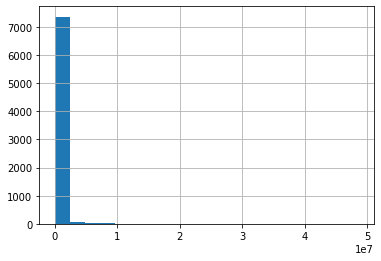

In [95]:
y_train_reg.hist(bins=20);

In [96]:
np.exp(np.log(y_train_reg+1))

3016    3.792141e+06
2569    5.656395e+05
2189    5.481558e+04
1166    7.762502e+05
959     1.000000e+00
            ...     
719     1.000000e+00
3975    2.223641e+06
9721    1.000000e+00
7684    8.350100e+04
1604    1.375100e+04
Name: sales_12M_2019, Length: 7503, dtype: float64

In [97]:
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor

In [98]:
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import RandomizedSearchCV
# import xgboost as xgb

In [99]:
def modified_log(x):
    x = np.where(x<0, 0, x)
    return np.log(x, where=x>0)

In [102]:
def modified_exp(x):
    x = np.where(x>15, 15, x)
    return np.expm1(x)

In [104]:
ttr = TransformedTargetRegressor(
        RidgeCV(), 
        func=np.log1p, 
        inverse_func=modified_exp, 
        check_inverse=False
)

In [106]:
ttr.fit(X_train_prepared, y_train_reg)

TransformedTargetRegressor(check_inverse=False, func=<ufunc 'log1p'>,
                           inverse_func=<function modified_exp at 0x000002C33CE6CEE8>,
                           regressor=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))

# Make predictions

## Regression

In [107]:
test_preds = pd.Series(ttr.predict(X_test_prepared), index=y_test_reg.index)
test_preds

6307         3.064226
4521        97.427806
7859        12.029382
110          8.572280
4238        22.707121
            ...      
5710       292.812887
6026        79.301902
6246    782764.457248
8059     32928.482550
6438        31.448920
Length: 2502, dtype: float64

In [108]:
ttr.score(X_test_prepared, y_test_reg)

0.034779944499192195

### Make Function to output deciles

In [109]:
def output_deciles(model, X, y):
    results = pd.DataFrame(model.predict(X), index=y.index, columns=['prediction'])
    results['actual'] = y.values
    results['deciles'] = pd.qcut(results['prediction'], 10, labels=False)
    results['contact_id'] = results.index.map(adviser_lookup)
    return results

In [110]:
result_df = output_deciles(ttr, X_test_prepared, y_test_reg)
result_df

,prediction,actual,deciles,contact_id
6307,3.064226,0.00,0,4495550
4521,97.427806,0.00,5,85102132724913032579
7859,12.029382,0.00,3,4380705
110,8.572280,25093.00,1,85102151525164324880
4238,22.707121,742.00,4,85101111303291084757
...,...,...,...,...
5710,292.812887,0.00,6,0056157
6026,79.301902,750051.80,5,85202111474542078472
6246,782764.457248,264238.31,9,85201140523379459042
8059,32928.482550,37576.85,8,85202111325248394877


In [112]:
result_df[result_df['deciles'] == 9]

,prediction,actual,deciles,contact_id
2990,5.409740e+05,7.189395e+04,9,4353864
6452,6.952845e+04,7.314998e+06,9,85202112173254510211
324,2.408189e+06,3.341190e+06,9,85101122913914154200
8940,1.683491e+06,1.319240e+06,9,4357613
4194,3.269016e+06,1.225482e+06,9,4434645
...,...,...,...,...
4048,5.247587e+04,2.865495e+05,9,4331182
6461,1.150358e+05,7.594300e+04,9,85201131374086410352
8853,9.317475e+05,9.053720e+05,9,0347664
6265,7.345901e+04,9.170000e+02,9,4493012


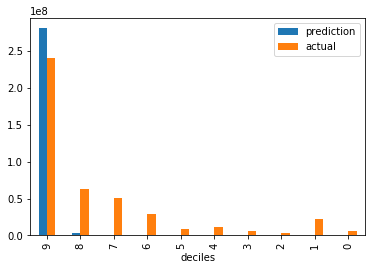

In [126]:
result_df.drop(columns='contact_id').groupby('deciles').sum().sort_index(ascending=False).plot(kind='bar');

# Classification

In [130]:
y_train_cl.head()

3016    1
2569    1
2189    1
1166    0
959     0
Name: new_Fund_added_12M_2019, dtype: int64

In [133]:
y_test_cl.value_counts()

0    1861
1     641
Name: new_Fund_added_12M_2019, dtype: int64

In [135]:
from sklearn.ensemble import GradientBoostingClassifier

In [136]:
gbt_base = GradientBoostingClassifier()
gbt_base.fit(X_train_prepared, y_train_cl)
test_pred_class = gbt_base.predict(X_test_prepared)
print(classification_report(y_test_cl, test_pred_class))

              precision    recall  f1-score   support

           0       0.76      0.97      0.85      1861
           1       0.52      0.10      0.17       641

    accuracy                           0.75      2502
   macro avg       0.64      0.54      0.51      2502
weighted avg       0.70      0.75      0.68      2502



In [139]:
def output_deciles_class(model, X, y):
    results = pd.DataFrame(model.predict_proba(X)[:,1], index=y.index, columns=['prediction'])
    results['actual'] = y.values
    results['deciles'] = pd.qcut(results['prediction'], 10, labels=False)
    results['contact_id'] = results.index.map(adviser_lookup)
    return results.sort_values(by='prediction', ascending=False)

In [141]:
output_deciles_class(gbt_base, X_train_prepared, y_train_cl)

,prediction,actual,deciles,contact_id
1783,0.932667,1,9,85101103674323007541
7325,0.914916,1,9,4417770
7629,0.914758,1,9,0215284
6867,0.914558,1,9,0232384
5035,0.899724,1,9,4316840
...,...,...,...,...
7905,0.071795,0,0,0035524
5275,0.071207,0,0,0298171
9418,0.069437,0,0,4484142
974,0.067010,0,0,0025009


## Balance the data with imbalanced-learn

In [144]:
from imblearn.over_sampling import SMOTE

In [147]:
# instantiate SMOTENC
smote = SMOTE(random_state=0)

# balance data
X_smote, y_smote = smote.fit_resample(X_train_prepared, y_train_cl)

In [148]:
y_smote.value_counts()

1    5623
0    5623
Name: new_Fund_added_12M_2019, dtype: int64

In [149]:
gbt_base2 = GradientBoostingClassifier()
gbt_base2.fit(X_smote, y_smote)
test_pred_class2 = gbt_base2.predict(X_test_prepared)
print(classification_report(y_test_cl, test_pred_class2))

              precision    recall  f1-score   support

           0       0.83      0.78      0.81      1861
           1       0.46      0.54      0.50       641

    accuracy                           0.72      2502
   macro avg       0.65      0.66      0.65      2502
weighted avg       0.74      0.72      0.73      2502

